# Chemical Potential and Compressibility

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from multirods_gpe.style import set_base_style
from multirods_gpe import MultiRods
from multirods_gpe.bloch import ideal_eigen_states, IdealState, GPEState, GPEStateSet
from multirods_gpe.spectrum import IdealSpectrum, GPESpectrum, GPEBlochStateType
from multirods_gpe.model import ER

In [3]:
from itertools import cycle, islice
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

## EDIT: Paths and non-standard imports >>>

In [4]:
import os, sys
proj_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
sys.path.insert(0, proj_dir)

### <<< End of paths and non-standard import
----

## Square lattice, $b = a$

In [5]:
def walk_interaction(v0, r, gn0_array, macro_kz):
    """"""
    states = []
            
    current = None
    for gn0 in sort(gn0_array):
        
        system = MultiRods(v0, r, gn0)
        system.context.partition_order = 8
        
        if current is None:
            ideal_states = ideal_eigen_states(system, momentum=macro_kz, max_eigen_states=10)
            ideal_state = ideal_states.get(bloch_band=1)
            current = ideal_state

        if gn0 != 0:
            gpe_state = GPEState.from_state(current, momentum=macro_kz, system=system)
            current = gpe_state
            
        states.append(current)
    
    return states

In [11]:
r = 1

# v0_range = array([0.01 * ER, 5, 10, 15, 25]) * ER
v0_range = linspace(0.01, 25, 26) * ER
# The default range for interactions
gn0_array = linspace(0, 25, 26) * ER

In [12]:
v0 = v0_range[1]
macro_kz = 0

# gpe_states = walk_interaction(v0, r, gn0_array, macro_kz)

### Calculating compressibility.

In [13]:
from scipy.integrate import trapz

In [14]:
from scipy.interpolate import splrep, splev

In [16]:
full_states_data = []
for v0 in v0_range:
    gpe_states = walk_interaction(v0, r, gn0_array, macro_kz)
    data_states = []
    
    for state in gpe_states:
        gn0 = state.system.interaction_strength
        e_kz = state.energy
        if isinstance(state, IdealState):
            mu_kz = e_kz
        else:
            mu_kz = state.chemical_potential

        data_states.append([v0, gn0, mu_kz, e_kz])

    full_states_data.append(data_states)
#     data_states = array(data_states)
    print('Completed for v0 / ER={}'.format(v0 / ER))

full_states_data = array(full_states_data)

C:\Users\oarodriguez\Academic Projects\MultiRodsGPE\multirods_gpe\bloch.py:325: ComplexWarning: Casting complex values to real discards the imaginary part
  funcs_mesh = p_fn_mesh.astype(np.float64), q_fn_mesh


Completed for v0 / ER=0.01
Completed for v0 / ER=1.0095999999999998
Completed for v0 / ER=2.0092
Completed for v0 / ER=3.0087999999999995
Completed for v0 / ER=4.0084
Completed for v0 / ER=5.007999999999999
Completed for v0 / ER=6.007599999999999
Completed for v0 / ER=7.007199999999999
Completed for v0 / ER=8.0068
Completed for v0 / ER=9.0064
Completed for v0 / ER=10.005999999999998
Completed for v0 / ER=11.0056
Completed for v0 / ER=12.005199999999999
Completed for v0 / ER=13.0048
Completed for v0 / ER=14.004399999999999
Completed for v0 / ER=15.004
Completed for v0 / ER=16.0036
Completed for v0 / ER=17.0032
Completed for v0 / ER=18.0028
Completed for v0 / ER=19.0024
Completed for v0 / ER=20.002
Completed for v0 / ER=21.0016
Completed for v0 / ER=22.0012
Completed for v0 / ER=23.0008
Completed for v0 / ER=24.0004
Completed for v0 / ER=25.0


In [17]:
full_states_data.tofile('full_data_states-02')

In [18]:
DASHES = [
    (5, 0.01),                  # "Solid"
    (5, 5/4),                   # Dash small-space
    (5, 5/4, 5/4, 5/4),         # Dash-dot
    (5/4, 5/4),                 #  Dot
    (5, 5/4, 5/2, 5/4, 5/2, 5/4),         # Dash, small-dash
    (2, 1, 1, 1),    # Dot-dash
    (4, 1, 1, 1),   # Long dash - dot
    (4, 1, 2, 1),   # Long dash - dot
    (6, 1)
]


### Plot chemical potential as $gn_0 / E_R$

In [19]:
def make_plot_label(v0_er, r, gn0_er):
    """"""
    v0_lbl = r'$V_0 = E_R$' if v0_er == 1 else r'$V_0 = {:.5G}E_R$'.format(v0_er) 
    r_lbl =  r'$b = a$' if r == 1 else r'b = ${:.5G}a$'.format(r)
    gn0_lbl = r'$gn_0 = E_R$' if gn0_er == 1 else r'$gn_0 = {:.5G}E_R$'.format(gn0_er)
    lbl = v0_lbl + '\n' + r_lbl + '\n' + gn0_lbl
    
    return lbl

C:\Users\oarodriguez\Academic Projects\PhDCode\reports\figures\mu-kz_kappa_as-gn0_r-1.pdf


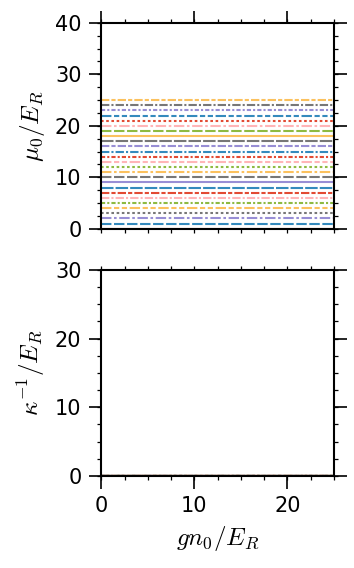

In [20]:
# Physical parameters
macro_kz = 0
bloch_band = 1

# %% Figure base style
set_base_style()

fig = figure(figsize=(2, 4))
gs = GridSpec(2, 1, figure=fig, )

rcParams['legend.fontsize'] = 8

# Switches
subplot_left = True
if subplot_left:
    add_legend = False
else:
    add_legend = True

# Upper subplot    
ax = subplot(gs[0, 0])

dashes = cycle(DASHES)

 # Some dimensions
y_min = 0
y_max = 40

skip_ideal = False
lc = None
gn0 = None

lc_ideal = None
for ctr, data_states in enumerate(full_states_data.transpose(1, 0, 2)):
    
    gn0_array_ = data_states[:, 0] / ER
    mu_kz_array = data_states[:, 1] / ER
    e_kz_array = data_states[:, 2] / ER
    
    mu_kz_rep = splrep(gn0_array_, mu_kz_array, k=4)
    kappa_array = splev(gn0_array_, mu_kz_rep, der=1)
    
    dash = next(dashes)
#     if system.interaction_strength:
# #         phi_k = absolute(state.wave_fn) ** 2
#         plb = r'${:5G}$'.format(gn0 / ER)
#     else:
# #         phi_k = absolute(state.wave_fn) ** 2
#         plb = None

    lc_ideal = None
    kappa_array *= gn0_array_
    if ctr == 0:
        line, = ax.plot(gn0_array_, mu_kz_array, color=lc_ideal, lw=1.0)
    else:
        line, = ax.plot(gn0_array_, mu_kz_array, color=lc_ideal, dashes=dash,
                        lw=1.0)

# print(gn0 / ER)
# plt_lb = make_plot_label(v0 / ER, r, gn0 / ER)
# ax.text(-0.44, 0.80 * y_max, plt_lb, fontsize=11)

add_legend = False
if add_legend:
    legend_ = ax.legend(bbox_to_anchor=(0.59, 0.715), loc='best')
    leg_title = legend_.get_title()
    legend_.set_title(r'$gn_0 / E_R$', prop=dict(size=9))
    leg_frame = legend_.get_frame()
    setp(leg_frame, fc='#FFFFFF', alpha=0.5)
    

y_loc = MultipleLocator(10)
y_fmt = FormatStrFormatter('%d')
y_min_loc = MultipleLocator(2.5)

ax.yaxis.set_major_locator(y_loc)
ax.yaxis.set_major_formatter(y_fmt)
ax.yaxis.set_minor_locator(y_min_loc)

x_loc = MultipleLocator(10)
x_fmt = FormatStrFormatter('%d')
x_min_loc = MultipleLocator(2.5)

ax.xaxis.set_major_locator(x_loc)
ax.xaxis.set_major_formatter(x_fmt)
ax.xaxis.set_minor_locator(x_min_loc)

# Remove bottom major ticks
ax.tick_params(bottom=False, which='major') 

ax.set_xlim(0, 25)
ax.set_ylim(y_min, y_max)

ax.xaxis.set_ticklabels([])

ax.set_ylabel(r'$\mu_0 / E_R$')

# ********************* Lower subplot **********************
ax = subplot(gs[1, 0])

dashes = cycle(DASHES)

 # Some dimensions
y_min = 0
y_max = 30

skip_ideal = False
lc = None
gn0 = None

lc_ideal = None
for ctr, data_states in enumerate(full_states_data.transpose(1, 0, 2)):
    
    gn0_array_ = data_states[:, 0] / ER
    mu_kz_array = data_states[:, 1] / ER
    e_kz_array = data_states[:, 2] / ER
    
    mu_kz_rep = splrep(gn0_array_, mu_kz_array, k=4)
    kappa_array = splev(gn0_array_, mu_kz_rep, der=1)
    
    dash = next(dashes)
#     if system.interaction_strength:
# #         phi_k = absolute(state.wave_fn) ** 2
#         plb = r'${:5G}$'.format(gn0 / ER)
#     else:
# #         phi_k = absolute(state.wave_fn) ** 2
#         plb = None

    lc_ideal = None
    kappa_array *= gn0_array_
    if ctr == 0:
        line, = ax.plot(gn0_array_, kappa_array, color=lc_ideal, lw=1.0)
    else:
        line, = ax.plot(gn0_array_, kappa_array, color=lc_ideal, dashes=dash,
                        lw=1.0)
        
y_loc = MultipleLocator(10)
y_fmt = FormatStrFormatter('%d')
y_min_loc = MultipleLocator(2.5)

ax.yaxis.set_major_locator(y_loc)
ax.yaxis.set_major_formatter(y_fmt)
ax.yaxis.set_minor_locator(y_min_loc)
        
ax.xaxis.set_major_locator(x_loc)
ax.xaxis.set_major_formatter(x_fmt)
ax.xaxis.set_minor_locator(x_min_loc)

ax.set_xlabel(r'$g n_0 / E_R$')
ax.set_ylabel(r'$\kappa^{-1} / E_R$')

# Remove upper major ticks
ax.tick_params(top=False, which='major') 

ax.set_xlim(0, 25)
ax.set_ylim(y_min, y_max)

# Some manual labelling
# ax.set_xticks([-0.5, 0, .5])
# ax.set_xticklabels([-.5, '0', .5])

fn_fmt = r'mu-kz_kappa_as-gn0_r-{:.5G}'
file_name = fn_fmt.format(r)

full_path = os.path.join(proj_dir,
                         'reports', 'figures',
                         '{:s}.pdf'.format(file_name.replace('.', '-dot-')))

# fn_fmt = r'ekz[int]_v0-{:.5G}_r-{:.5G}_gn0-{:.5G}'
# file_name = fn_fmt.format(v0 / ER, r, gn0 / ER)

# full_path = os.path.join(proj_dir,
#                          'reports', 'figures',
#                          '{:s}.pdf'.format(file_name.replace('.', '-dot-')))

# savefig(full_path)

print(full_path)

### Plot compressibility as $gn_0 / E_R$

C:\Users\oarodriguez\Academic Projects\PhDCode\reports\figures\kappa[int]-as-gn0_r-1.pdf


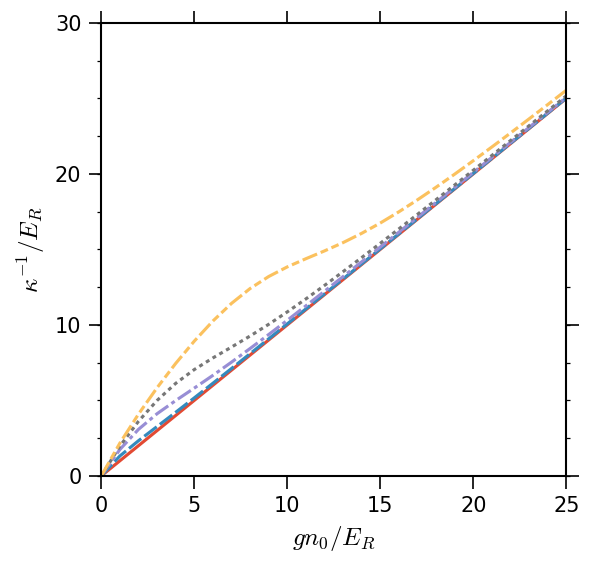

In [89]:
# Physical parameters
macro_kz = 0
bloch_band = 1

# %% Figure base style
set_base_style()

figure(figsize=(4, 4))

ax = gca()

rcParams['legend.fontsize'] = 8

dashes = cycle(DASHES)

# Switches
subplot_left = True
if subplot_left:
    add_legend = False
else:
    add_legend = True

 # Some dimensions
y_min = 0
y_max = 30

skip_ideal = False
lc = None
gn0 = None

lc_ideal = None
for ctr, data_states in enumerate(full_states_data):
    
    gn0_array_ = data_states[:, 0] / ER
    mu_kz_array = data_states[:, 1] / ER
    e_kz_array = data_states[:, 2] / ER
    
    mu_kz_rep = splrep(gn0_array_, mu_kz_array, k=4)
    kappa_array = splev(gn0_array_, mu_kz_rep, der=1)
    
    dash = next(dashes)
#     if system.interaction_strength:
# #         phi_k = absolute(state.wave_fn) ** 2
#         plb = r'${:5G}$'.format(gn0 / ER)
#     else:
# #         phi_k = absolute(state.wave_fn) ** 2
#         plb = None

    lc_ideal = None
    kappa_array *= gn0_array_
    if ctr == 0:
        line, = ax.plot(gn0_array_, kappa_array, color=lc_ideal, lw=1.5)
    else:
        line, = ax.plot(gn0_array_, kappa_array, color=lc_ideal, dashes=dash,
                        lw=1.5)

# print(gn0 / ER)
# plt_lb = make_plot_label(v0 / ER, r, gn0 / ER)
# ax.text(-0.44, 0.80 * y_max, plt_lb, fontsize=11)

add_legend = False
if add_legend:
    legend_ = ax.legend(bbox_to_anchor=(0.59, 0.715), loc='best')
    leg_title = legend_.get_title()
    legend_.set_title(r'$gn_0 / E_R$', prop=dict(size=9))
    leg_frame = legend_.get_frame()
    setp(leg_frame, fc='#FFFFFF', alpha=0.5)
    

y_loc = MultipleLocator(10)
y_fmt = FormatStrFormatter('%d')
y_min_loc = MultipleLocator(2.5)

ax.yaxis.set_major_locator(y_loc)
ax.yaxis.set_major_formatter(y_fmt)
ax.yaxis.set_minor_locator(y_min_loc)

ax.set_xlabel(r'$gn_0 / E_R$')
ax.set_ylabel(r'$\kappa^{-1} / E_R$')

ax.set_xlim(0, 25)
ax.set_ylim(y_min, y_max)

# Some manual labelling
# ax.set_xticks([-0.5, 0, .5])
# ax.set_xticklabels([-.5, '0', .5])

fn_fmt = r'kappa[int]-as-gn0_r-{:.5G}'
file_name = fn_fmt.format(r)

full_path = os.path.join(proj_dir,
                         'reports', 'figures',
                         '{:s}.pdf'.format(file_name.replace('.', '-dot-')))

# fn_fmt = r'ekz[int]_v0-{:.5G}_r-{:.5G}_gn0-{:.5G}'
# file_name = fn_fmt.format(v0 / ER, r, gn0 / ER)

# full_path = os.path.join(proj_dir,
#                          'reports', 'figures',
#                          '{:s}.pdf'.format(file_name.replace('.', '-dot-')))

# savefig(full_path)

print(full_path)